# Benchmark latency for Amazon Bedrock models
Use this notebook to measure model latency in Amazon Bedrock.  
Start by:
1. Specifying scenarios to test (`scenarios`)
2. Execute benchmark
3. Reporting - Observe results statistics as data and graphs.

# Specifying scenarios to test

Here are various possible scenarios to benchmark.
Each scenario is a dictionary with latency relevant keys:
- `model_id` - the model to test, smaller models are likely slower. Currently only Anthropic models are supported.
- `in_tokens` - the number of tokens to feed to the model. aka: input context length. Range: 40 - 100K.
- `out_tokens` - the number of tokens for the model to generate. Range: 1 - 8191.
- `region` - The AWS region to invoke Bedrock in. This can affect network latency depending on client location.
- `stream` - True|False - A streaming response starts returning tokens to the client as they are generated, instead of waiting before returning the complete resopnses. This should be True for interactive use cases.
- `name` - a human readable name for the scenario (will appear in reports and graphs).

In [20]:
use_cases_scenarios = [
            {
                'model_id'    : 'anthropic.claude-v2',
                'in_tokens'  : 1000,
                'out_tokens' : 200,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'Summarization. in=1000, out=200',
            },
            {
                'model_id'    : 'anthropic.claude-v2',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'Classification. in=200, out=50',
            },
]

region_compare_scenarios = [
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens'  : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'us-east-1',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-west-2',
                'stream' : True,
                'name' : f'us-west-2',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'eu-central-1',
                'stream' : True,
                'name' : f'eu-central-1',
            },
]

model_compare_scenarios = [
            {
                'model_id'    : 'anthropic.claude-v2',
                'in_tokens'  : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'claude-v2. in=200, out=50',
            },
            {
                'model_id'    : 'anthropic.claude-instant-v1',
                'in_tokens' : 200,
                'out_tokens' : 50,
                'region'     : 'us-east-1',
                'stream' : True,
                'name' : f'claude-instant-v1. in=200, out=50',
            },
]

Uncomment your desired scenario

In [21]:
# Uncomment the scenario you want:
#scenarios = use_cases_scenarios.copy()
scenarios = region_compare_scenarios.copy()
#scenarios = model_compare_scenarios.copy()

# The number of times to benchmark each scenario. 
# This is important in measuring variance and average response time across a long duration.
invocations_per_scenario = 2 

# Seconds to sleep between each invocation. (0 is no sleep). Sleeping between invocation can help you measure across longer periods of time, and/or avoid throttling.
sleep_between_invocations = 5

# Install needed dependencies
This notebook requires a Python 3 environment

In [22]:
!pip install --quiet --upgrade pip
!pip install --quiet --upgrade boto3 awscli matplotlib numpy pandas anthropic

# Helper functions


In [23]:
import boto3, botocore, os
import random 
import anthropic

anthropic_client = anthropic.Anthropic() # used to count tokens only

# This internal method will include arbitrary long input that is designed to generate an extremely long model output
def _get_prompt_template(num_input_tokens):
    tokens = 'Human:'
    tokens += 'Ignore X' + '<X>'
    for i in range(num_input_tokens-1):
        tokens += random.choice(['hello', 'world', 'foo', 'bar']) + ' '
    tokens += '</X>'
    tokens += "print numbers 1 to 9999 as words. don't omit for brevity"
    tokens += '\n\nAssistant:one two'  # model will continue with " three four five..."
    return tokens

''' 
This method creates a prompt of input length `expected_num_tokens` which instructs the LLM to generate extremely long model resopnse
'''
def create_prompt(expected_num_tokens):
    num_tokens_in_prompt_template = anthropic_client.count_tokens(_get_prompt_template(0))
    additional_tokens_needed = max(expected_num_tokens - num_tokens_in_prompt_template,0)
    
    prompt_template = _get_prompt_template(additional_tokens_needed)
    
    actual_num_tokens = anthropic_client.count_tokens(prompt_template)
    #print(f'expected_num_tokens={expected_num_tokens}, actual_tokens={actual_num_tokens}')
    assert expected_num_tokens==actual_num_tokens, f'Failed to generate prompt at required length: expected_num_tokens{expected_num_tokens} != actual_num_tokens={actual_num_tokens}'
    
    return prompt_template

In [24]:
import time, json
from botocore.exceptions import ClientError
sleep_on_throttling_sec = 5

def benchmark(bedrock, prompt, max_tokens_to_sample, stream=True, temprature=0):
    modelId = 'anthropic.claude-v2'
    accept = 'application/json'
    contentType = 'application/json'
    
    body = json.dumps({
    "prompt": prompt,
    "max_tokens_to_sample": max_tokens_to_sample,
    "temperature": 0,
})
    while True:
        try:
            start = time.time()

            if stream:
                response = bedrock.invoke_model_with_response_stream(body=body, modelId=modelId, accept=accept, contentType=contentType)
            else:
                response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
            #print(response)
            
            first_byte = None
            if stream:
                event_stream = response.get('body')
                for event in event_stream:
                    chunk = event.get('chunk')
                    if chunk:
                        if not first_byte:
                            first_byte = time.time() # update the time to first byte
                        #print(f'chunk:\n {json.loads(chunk.get('bytes').decode())}')
                # end of stream - check stop_reson in last chunk
                stop_reason = json.loads(chunk.get('bytes').decode())['stop_reason']    
                last_byte = time.time()
            else:
                #no streaming flow
                first_byte = time.time()
                last_byte = first_byte
                response_body = json.loads(response.get('body').read())
                stop_reason = response_body['stop_reason']

            
            # verify we got all of the intended output tokens by verifying stop_reason
            assert stop_reason == 'max_tokens', f"stop_reason is {stop_reason} instead of 'max_tokens', this means the model generated less tokens than required."

            duration_to_first_byte = first_byte - start
            duration_to_last_byte = last_byte - start
        except ClientError as err:
            if 'Thrott' in err.response['Error']['Code']:
                print(f'Got ThrottlingException. Sleeping {sleep_on_throttling_sec} sec and retrying.')
                time.sleep(sleep_on_throttling_sec)
                continue
            raise err
        break
    return duration_to_first_byte, duration_to_last_byte

In [25]:
import time
''' 
Get a boto3 bedrock runtime client for invoking requests
region - the AWS region to use
Note: Removing auto retries to ensure we're measuring a single transcation (e.g., in case of throttling).
'''
def _get_bedrock_client(region, warmup=True):
    client = boto3.client( service_name='bedrock-runtime',
                          region_name=region,
                          config=botocore.config.Config(retries=dict(max_attempts=0))) 
    if warmup:
        benchmark(client, create_prompt(50), 1)
    return client

'''
Get a possible cache client per AWS region 
'''
client_per_region={}
def get_cached_client(region):
    if client_per_region.get(region) is None:
        client_per_region[region] = _get_bedrock_client(region)
    return client_per_region[region]


def post_iteration(is_last_invocation):
    if sleep_between_invocations > 0 and not is_last_invocation:
        print(f'Sleeping for {sleep_between_invocations} seconds.')
        time.sleep(sleep_between_invocations)
        
            

# Execute the benchmark

In [26]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

early_break = False # early breaking will break after a single scenario, useful for debugging.

for scenario in scenarios:
    for i in range(invocations_per_scenario): # increase to sample each use case more than once to discover jitter
        try:
            prompt = create_prompt(scenario['in_tokens'])
            client = get_cached_client(scenario['region'])
            time_to_first_token,time_to_last_token = benchmark(client, prompt, scenario['out_tokens'], stream=scenario['stream'])

            if 'durations' not in scenario: scenario['durations'] = list()
            duration = {
                'time-to-first-token':  time_to_first_token,
                'time-to-last-token':  time_to_last_token,
            }
            scenario['durations'].append(duration)

            print(f"Scenario: [{scenario['name']}, " + 
                  f'Duration: {pp.pformat((duration))}')
            
            post_iteration(is_last_invocation = i == invocations_per_scenario - 1)
        except Exception as e:
            print(e)
            print(f"Error while processing scenario: {scenario['name']}.")
        if early_break:
            break

Scenario: [us-east-1, Duration: { 'time-to-first-token': 0.5413880348205566,
  'time-to-last-token': 1.2584638595581055}
Sleeping for 5 seconds.
Scenario: [us-east-1, Duration: { 'time-to-first-token': 0.8078141212463379,
  'time-to-last-token': 1.537724256515503}
Scenario: [us-west-2, Duration: { 'time-to-first-token': 1.184631109237671,
  'time-to-last-token': 2.0457868576049805}
Sleeping for 5 seconds.
Scenario: [us-west-2, Duration: { 'time-to-first-token': 1.6891717910766602,
  'time-to-last-token': 5.305222749710083}
Scenario: [eu-central-1, Duration: { 'time-to-first-token': 0.6747698783874512,
  'time-to-last-token': 1.4417150020599365}
Sleeping for 5 seconds.
Scenario: [eu-central-1, Duration: { 'time-to-first-token': 0.7489049434661865,
  'time-to-last-token': 1.5025699138641357}
An error occurred (ResourceNotFoundException) when calling the InvokeModelWithResponseStream operation: Could not resolve the foundation model from the provided model identifier.
Error while processi

# Reporting

In [27]:
pp.pprint(scenarios)

[ { 'durations': [ { 'time-to-first-token': 0.5413880348205566,
                     'time-to-last-token': 1.2584638595581055},
                   { 'time-to-first-token': 0.8078141212463379,
                     'time-to-last-token': 1.537724256515503}],
    'in_tokens': 200,
    'model_id': 'anthropic.claude-instant-v1',
    'name': 'us-east-1',
    'out_tokens': 50,
    'region': 'us-east-1',
    'stream': True},
  { 'durations': [ { 'time-to-first-token': 1.184631109237671,
                     'time-to-last-token': 2.0457868576049805},
                   { 'time-to-first-token': 1.6891717910766602,
                     'time-to-last-token': 5.305222749710083}],
    'in_tokens': 200,
    'model_id': 'anthropic.claude-instant-v1',
    'name': 'us-west-2',
    'out_tokens': 50,
    'region': 'us-west-2',
    'stream': True},
  { 'durations': [ { 'time-to-first-token': 0.6747698783874512,
                     'time-to-last-token': 1.4417150020599365},
                   { 'time-to-fir

KeyError: 'durations'

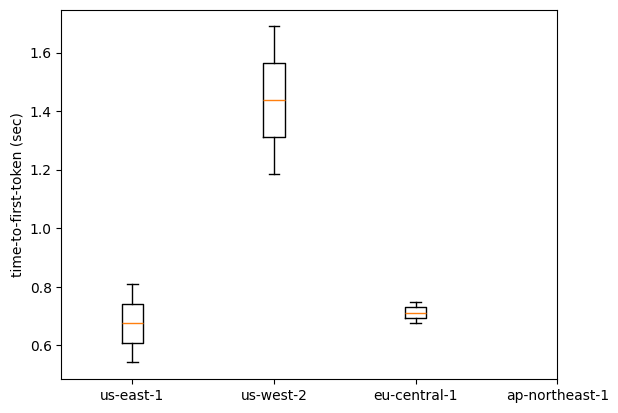

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

metric = 'time-to-first-token'
#metric = 'time-to-last-token'

for scenario in scenarios:
  durations = [d[metric] for d in scenario['durations']]
  
  ax.boxplot(durations, positions=[scenarios.index(scenario)])
  
  ax.set_xticks(range(len(scenarios)))
  ax.set_xticklabels([s['name'] for s in scenarios])
  
  ax.set_ylabel(f'{metric} (sec)')

fig.tight_layout()
plt.show()